In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [ ]:
# Load the dataset
df = pd.read_csv('drive/MyDrive/PulseTuneAI/heart_rate_emotion_dataset.csv')
print(df.head())

# Count the occurrences of each emotion
emotion_counts = df['Emotion'].value_counts()
print("\nCounts of each Emotion:")
print(emotion_counts)

# Loading the 30000 Spotify Dataset
df_spotify = pd.read_csv('drive/MyDrive/PulseTuneAI/spotify_songs.csv')
print(df_spotify.head())
print(df_spotify.describe())

   HeartRate  Emotion
0         65      sad
1         79  neutral
2         73  neutral
3        100    happy
4         99    angry

Counts of each Emotion:
Emotion
angry       14368
sad         14359
fear        14303
happy       14283
neutral     14258
disgust     14227
surprise    14202
Name: count, dtype: int64
                 track_id                                         track_name  \
0  6f807x0ima9a1j3VPbc7VN  I Don't Care (with Justin Bieber) - Loud Luxur...   
1  0r7CVbZTWZgbTCYdfa2P31                    Memories - Dillon Francis Remix   
2  1z1Hg7Vb0AhHDiEmnDE79l                    All the Time - Don Diablo Remix   
3  75FpbthrwQmzHlBJLuGdC7                  Call You Mine - Keanu Silva Remix   
4  1e8PAfcKUYoKkxPhrHqw4x            Someone You Loved - Future Humans Remix   

       track_artist  track_popularity          track_album_id  \
0        Ed Sheeran                66  2oCs0DGTsRO98Gh5ZSl2Cx   
1          Maroon 5                67  63rPSO264uRjW1X5E6cWv6   
2      

#Dataset Distributions

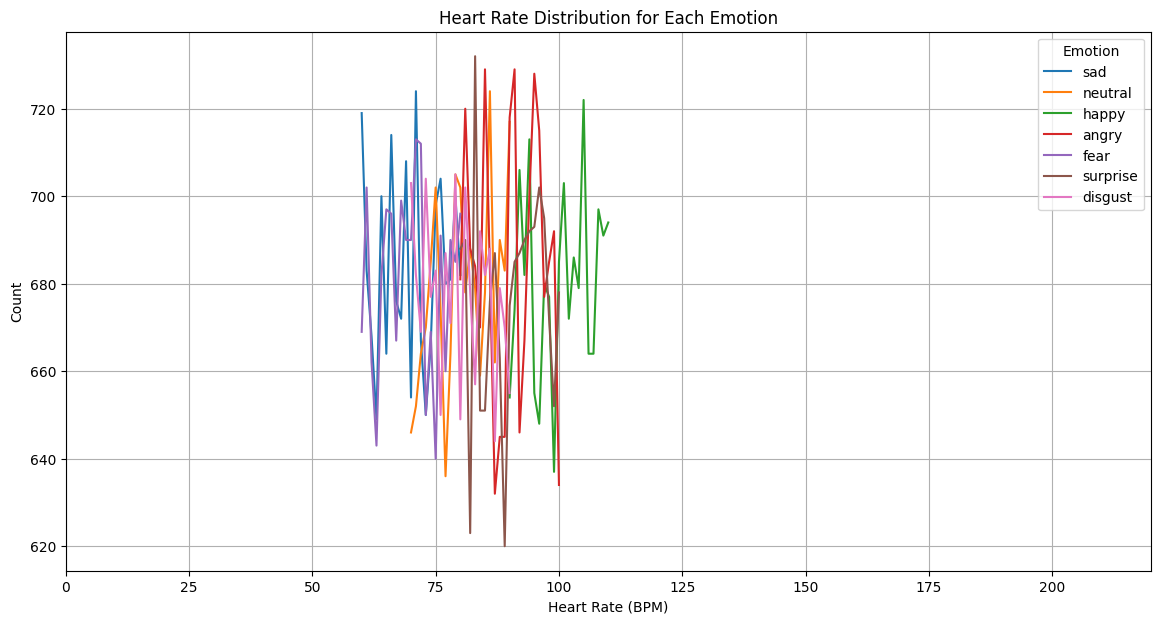

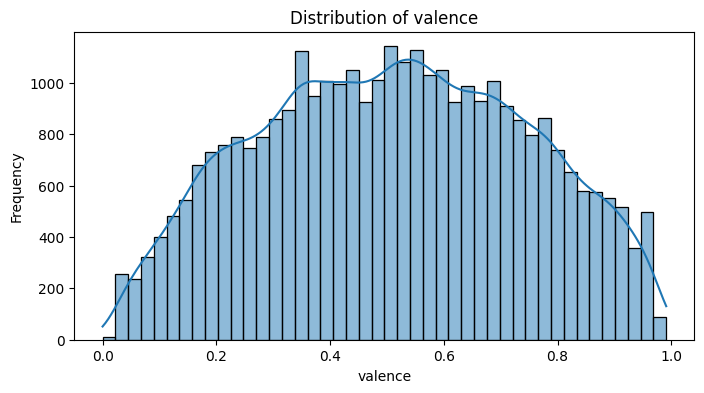

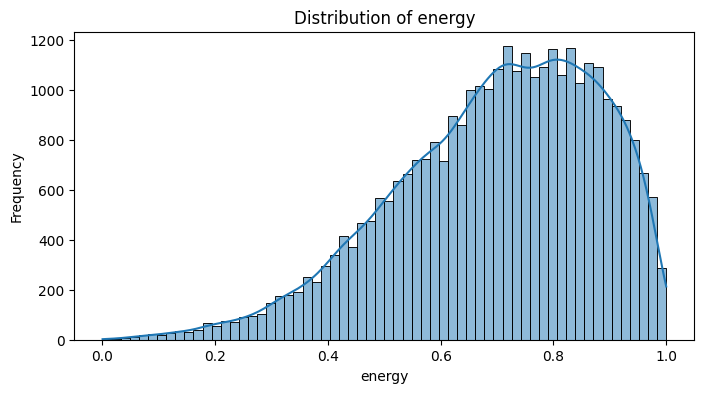

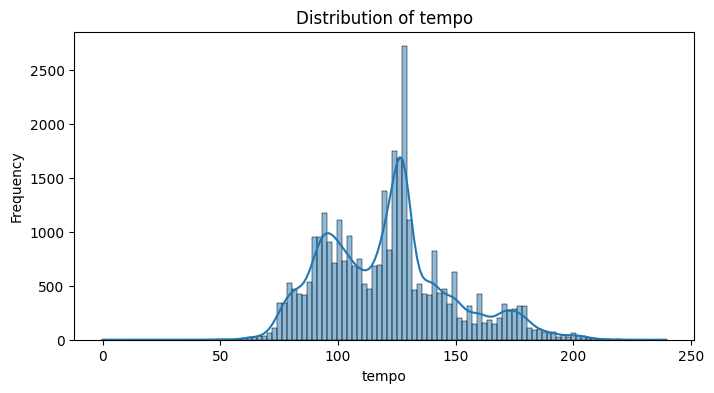

In [ ]:
plt.figure(figsize=(14, 7))

#plot the heart rate distribution
emotions = df['Emotion'].unique()
for emotion in emotions:
    emotion_data = df[df['Emotion'] == emotion]['HeartRate']
    heart_rate_counts = emotion_data.value_counts().sort_index()
    plt.plot(heart_rate_counts.index, heart_rate_counts.values, label=emotion)

plt.xlabel('Heart Rate (BPM)')
plt.ylabel('Count')
plt.title('Heart Rate Distribution for Each Emotion')
plt.xlim(0, 220)
plt.legend(title='Emotion')
plt.grid(True)

#displaying
plt.show()

# Want to visualize the distribution of some key features
featsToPlot = ["valence","energy","tempo"]

for feature in featsToPlot:
  plt.figure(figsize=(8,4))
  sns.histplot(df_spotify[feature], kde=True)
  plt.title(f"Distribution of {feature}")
  plt.xlabel(feature)
  plt.ylabel("Frequency")
  plt.show()


#Heart rate and Emotion Distribution

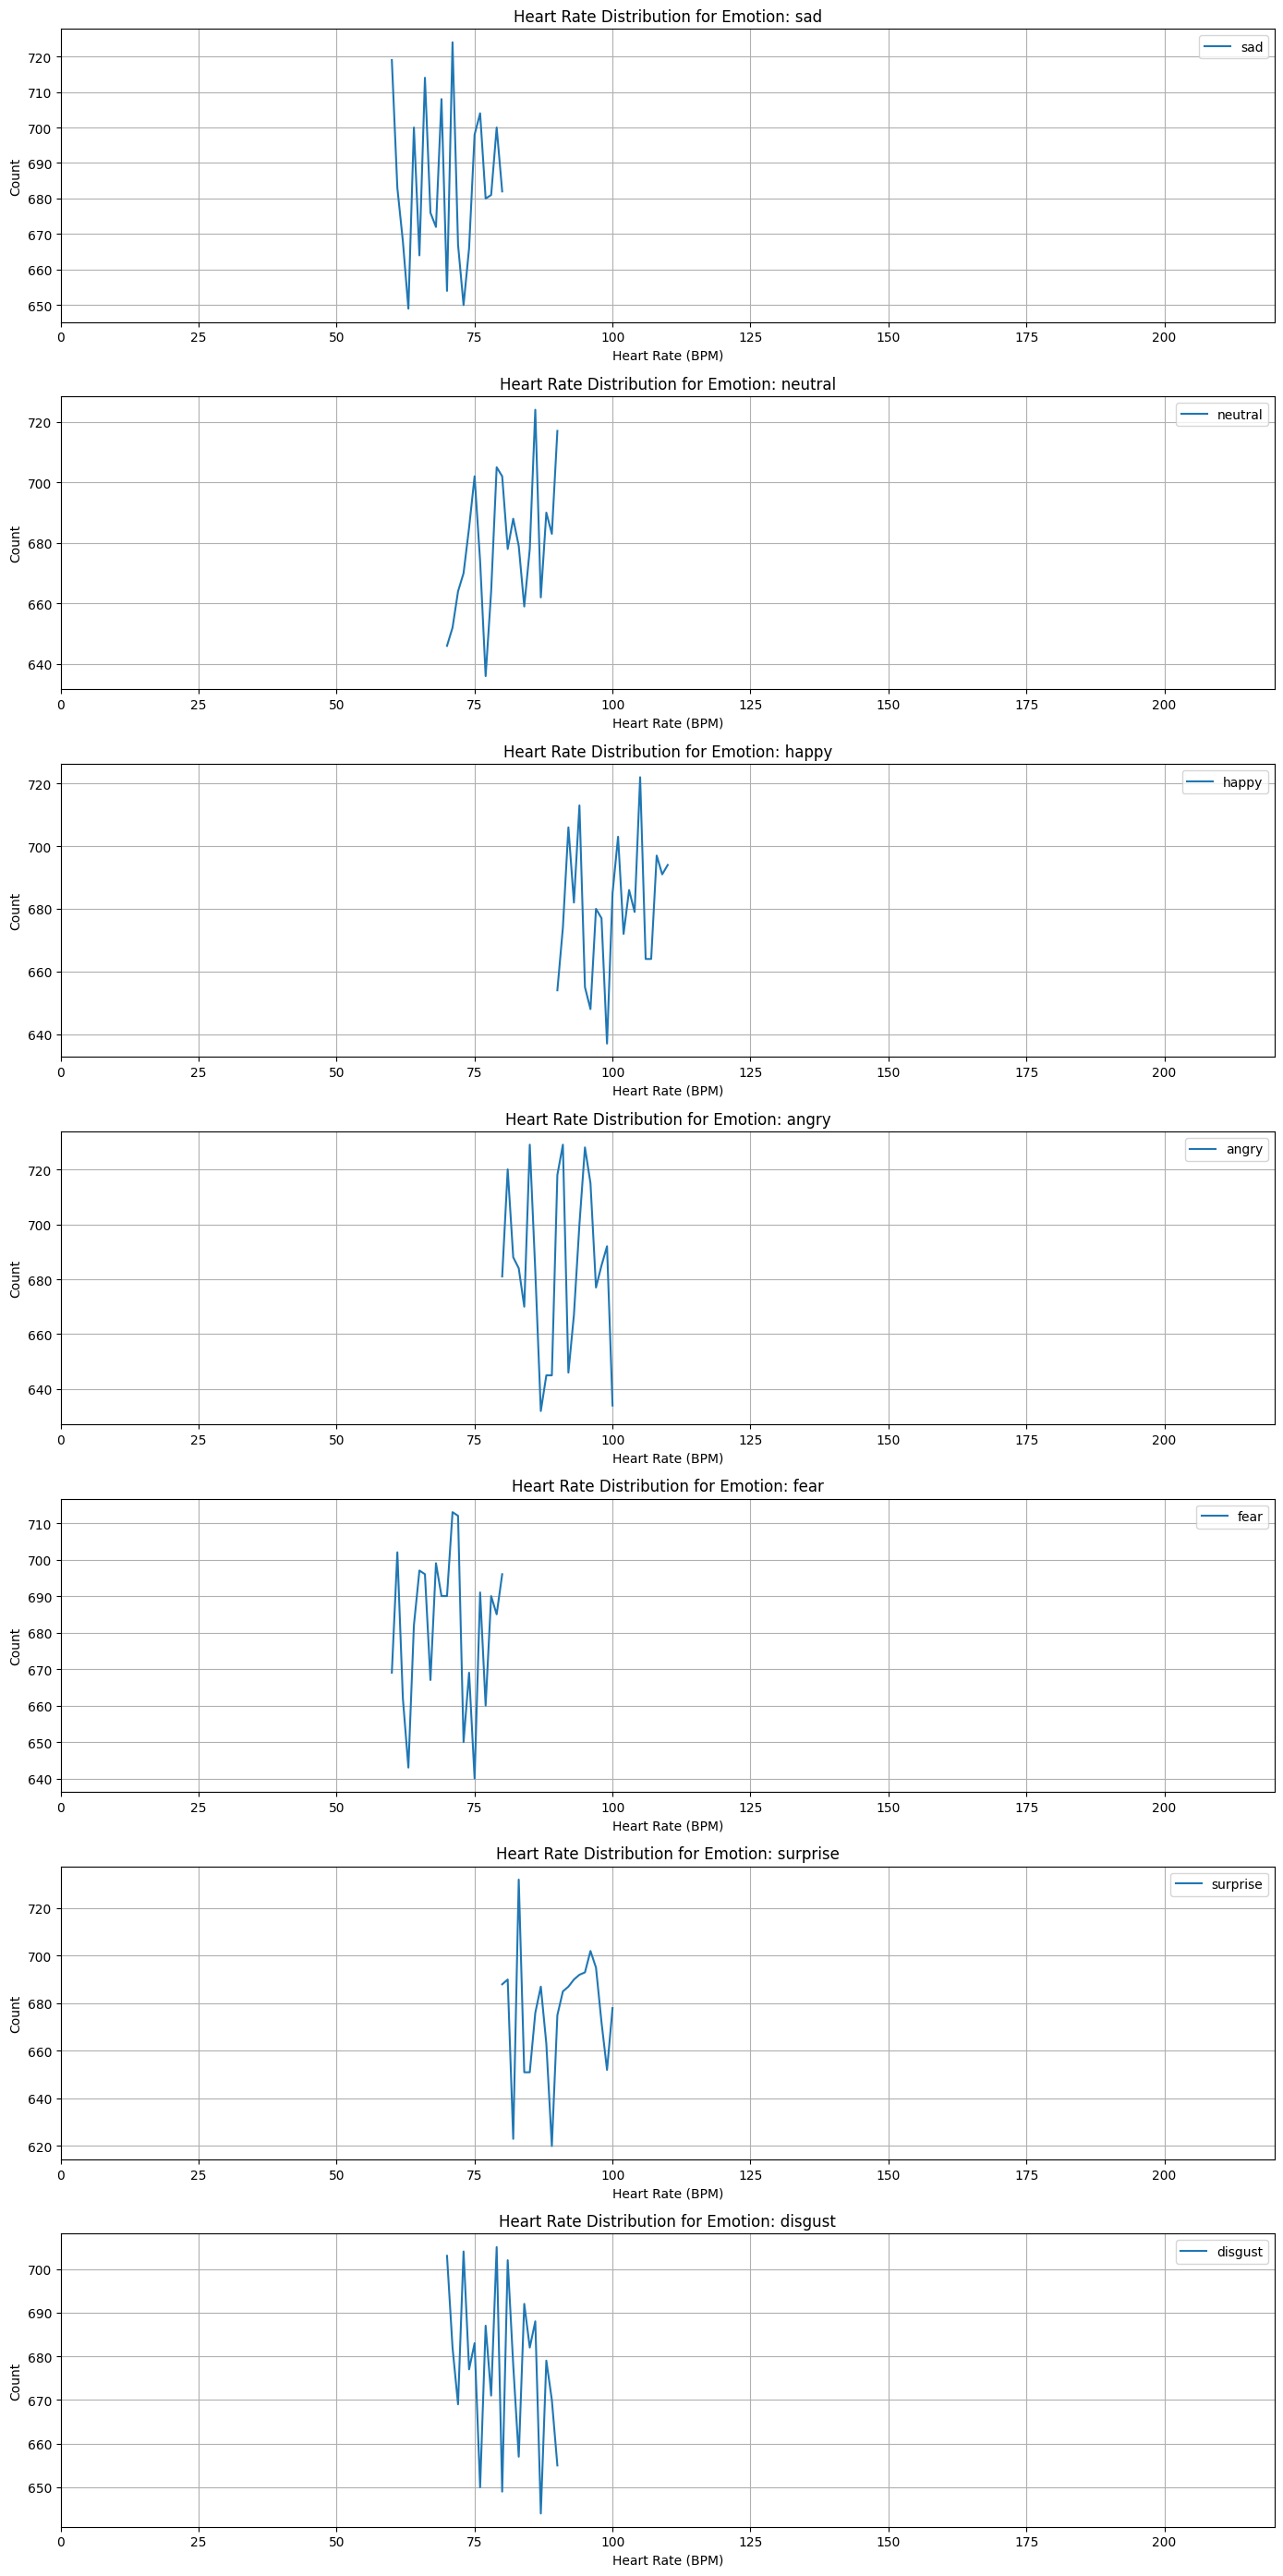

In [ ]:
# displaying the plot of each emotion individually
num_emotions = len(emotions)
plt.figure(figsize=(14, num_emotions * 4))

for i, emotion in enumerate(emotions, 1):
    plt.subplot(num_emotions, 1, i)
    emotion_data = df[df['Emotion'] == emotion]['HeartRate']
    heart_rate_counts = emotion_data.value_counts().sort_index()
    plt.plot(heart_rate_counts.index, heart_rate_counts.values, label=emotion, color='tab:blue')
    plt.xlabel('Heart Rate (BPM)')
    plt.ylabel('Count')
    plt.title(f'Heart Rate Distribution for Emotion: {emotion}')
    plt.xlim(0, 220)
    plt.grid(True)
    plt.legend()

plt.tight_layout()

# displaying
plt.show()


# Step 1: Cleaning the data and formatting the data
- convert the data to PyTorch tensors

In [ ]:
"""
We decide to use the oneHotEncoder method to process the emotion data, since they are represented as categorical features,
such as sad,happy inside we set the sparse_output to false because we want a dense matrix that are more appropriate
for the dataset with a few or none zero values
we choose to set the dtypes to be float32 because it has around 7 decimal places for precision, which
should be good enough for our model training, we also tries the float64 for more precise computation, but
thinking that it would consume significantly more memory and take longer time for computation.
"""
encode_converter = OneHotEncoder(sparse_output=False, dtype=np.float32)
"""We access the values of the Emotion's column and change from 1 dimensional array to 2 dimensional
array because the one hot encoding can only process the array with 2 dimensional"""
dimension_change = df['Emotion'].values.reshape(-1, 1)
"""We can just fit the data that we converted from one dimensional to 2 dimensional and fit those data into
the one hot encoder that we defined in the beginning """
y_encoded = encode_converter.fit_transform(dimension_change)

"""we initialize a x_tensor by applying the torch.tensor function, inside the function, we trieve the array from the
HeartRate and set it to be 2 dimensional array because we want to be consistent as we set the values in the emotion column
to be 2 dimensional previously for one hot encoding. The data type set to be float32 to save memory spaces and ensure a good
precision
Similarly, for the y_tensor, we just used the encoded values for the emotion_column and and set the data types to be float32 """
HR_dimensional_change = df['HeartRate'].values.reshape(-1, 1)
x_HR_tensor = torch.tensor(HR_dimensional_change, dtype=torch.float32)
y_EMO_tensor = torch.tensor(y_encoded, dtype=torch.float32)

"""
Select the features that will be used for clustering
Valence to indicate the positivity of a track which can align to happiness or sadness
Energy to indicate the intensity and activity of a track
Tempo to indicate the speed of the song
"""
features = df_spotify[["valence", "energy","tempo"]]
scaler = StandardScaler()
normalized_features = scaler.fit_transform(features)
df_spotify_scaled = pd.DataFrame(normalized_features, columns=features.columns)
print(df_spotify_scaled.head())


    valence    energy     tempo
0  0.031908  1.201614  0.042927
1  0.782522  0.643317 -0.777198
2  0.439384  1.284529  0.116227
3 -1.001795  1.279002  0.039953
4  0.919777  0.742815  0.115037


#Step 2: Dataset and DataLoader

In [ ]:
# Custom dataset class for sequential data
# We used the base class from the torch.utils.data module,allow us to access
# the pytorch's dataloader, which can handle the batching, shuffling during the
# model training
class HeartRateDataset(Dataset):
    def __init__(self, heart_rates, emotion, sequence_length=12):
        self.heart_rates = heart_rates
        self.emotion_label = emotion
        # we defined the sequence_length means that we would capture the last 12
        # readings of the user's heart rate data and feed that into our model
        self.sequence_length = sequence_length

    """Ensure we only create numbers of sequences that can fit in the range of
    the available data. Ex: if the number of heart rate is 100, the sequence is 12
    then the valid number of the sequence is 87 """
    def __len__(self):
        return len(self.heart_rates) - self.sequence_length + 1

    """It returns the specific sequences of the heart rate for the seq_HR_x
    and the specific sequences of the emotion labels array"""
    def __getitem__(self, idx):
        seq_HR_x = self.heart_rates[idx:idx + self.sequence_length].reshape(-1, 1)
        seq_EMO_y = self.emotion_label[idx + self.sequence_length - 1]

        # Ensure both are tensors of type float
        if not torch.is_tensor(seq_HR_x):
            seq_HR_x = torch.tensor(seq_HR_x)
        seq_HR_x = seq_HR_x.float()

        if not torch.is_tensor(seq_EMO_y):
            seq_EMO_y = torch.tensor(seq_EMO_y)
        seq_EMO_y = seq_EMO_y.float()

        # Make sure there are no conditions that prevent returning these tensors
        return seq_HR_x, seq_EMO_y


# Create dataset objects
# the legnth could be adjust as how many reading of the heart rate do you want to analyze from the users
sequence_length = 30
dataset = HeartRateDataset(x_HR_tensor, y_EMO_tensor, sequence_length=sequence_length)

"""Split dataset into training and validation sets
set 10 percent of the dataset to be validation data and 90 percent to be training data"""
validation_size = int(0.1 * len(dataset))
train_size = len(dataset) - validation_size
# use th random_split function to split the dataset into two subset with corresponding size
train_dataset, val_dataset = random_split(dataset, [train_size, validation_size])

# Create DataLoader objects
# we set the shuffle to be True because we want to randomize the data for the model to learn, reduce the overfitting
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# unnecessary for the validation dataset to randomized because it was used for comparision during the training
validation_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


***silhouette scores***

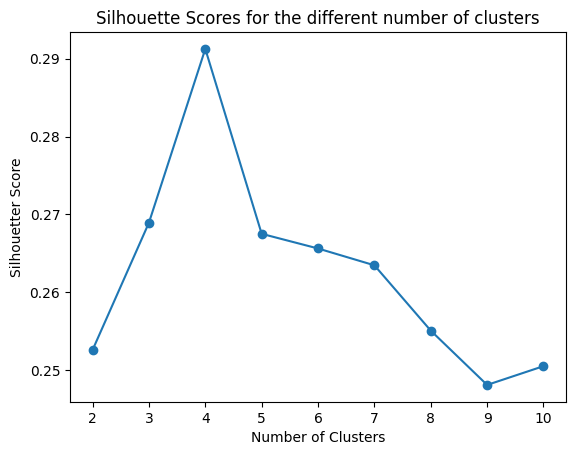

Optimal num of clusters is 4


In [ ]:
"""
Computes silhouette scores in order to validate the cluster quality.
Silhouette scores measures how similar a data points is to its own cluster compared
to other clusters.

"""
silhouette_scores = []

#Testing 2 to 10 clusters
for k in range(2, 11):
  kmeans = KMeans(n_clusters=k)
  cluster_labels = kmeans.fit_predict(normalized_features)
  silhouette_scores.append(silhouette_score(normalized_features, cluster_labels))

#Plotting out the silhouette scores
plt.plot(range(2,11),silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouetter Score')
plt.title('Silhouette Scores for the different number of clusters')
plt.show()
"""
The plot shows a peak at 4 clusters, which suggests that using 4 cluster would
be good for this dataset.
"""

optimal_clusters = silhouette_scores.index(max(silhouette_scores)) + 2
print(f"Optimal num of clusters is {optimal_clusters}")

In [ ]:
"""
Clustering helps simplify complex data by grouping songs with similar features.
It also helps with emotion mapping by organizing songs with distinct, and groups.

"""
kmeans = KMeans(n_clusters=optimal_clusters)
df_spotify['cluster'] = kmeans.fit_predict(normalized_features)

#Step 3: Model Definition

In [ ]:
# Define the RNN model for sequence data
# We inhert the nn.Module, which is a base class for neural network model building
class EmotionRNN(nn.Module):
    # intput_size = 1, as we record a number of the heart rate data at a time
    # hidden size = number of features in the hidden state, that can help the model to capture the pattern of the heart rate change
    # ouput_size = 1, as we are trying to predict a mood based on the heart rate
    # number of layers set to 1 as default, but we can adjust to higher number to capture more complex pattern if needed
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        # we use the super to get the access of the methods inside the parent class nn.Module of the EmotionRNN
        super(EmotionRNN, self).__init__()
        self.hidden_size = hidden_size
        # Created a long short term memory layers, which is a type of RNN layers that can use to analyze the sequential data and make the prediction
        # based on the tempoarl pattern that we capture. Ex: If the heart rate of the users are remain around 130 to 140, then he would identify as happy mood
        # As we set the batch_first to be true, the expected input shape would be (batch size, sequence length and input size)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        # we created a fully connected layers that used the last hidden state representation capture by the lstm layers and make the prediction
        # output size = number of output feature, since we just predict the mood, so the size would be 1
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # we initialize a hidden and cell tensor states for the long short term memory layers to process the sequences
        # and we put those two tensor in the same device, x.size(0) = batch size
        # hidden state represents the short term memory, capture the infor of the sequence as it process, however, once it
        # encounters the longer sequence, the previous information might be forget. (store the sequence output)
        # cell state carry the complete infor of the sequence throughout the entire process(memory of all the sequences)
        hidden_state = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        cell_state = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)

        # we let the input x process in the lstm layers with the two pre-defined hidden and cell states
        # since we only need the hidden state that store the sequence output
        out, _ = self.lstm(x, (hidden_state, cell_state))
        # print(out)
        # the out was represented as (batch size, sequence length and input size)
        out = out.select(1, -1) # selected the last time step(the last heart rate measurement within a min) for each sequence_length,
                                 #to see whther the user's heart rate was increase, or decrease
        # then we can put the output sequence into the fully connected layer that we defined to generate the prediction
        final_out = self.fc(out)
        return final_out

    """
    reference resources:
    https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module
    https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html
    https://medium.com/@humble_bee/rnn-recurrent-neural-networks-lstm-842ba7205bbf#:~:text=Cell%20State%20basically%20encodes%20the,step%20(at%20every%20step).&text=Cell%20state%20is%20a%20memory,an%20output%20of%20this%20cell.
    """


#Step 4: Model training

In [ ]:
input_size = 1
hidden_size = 100  # Adjust the num of hidden features to minimize the loss
# the output size = number of unique emotion labels within the dataset
output_size = y_encoded.shape[1]
print("y_encoded shape:", y_encoded.shape)
num_epochs = 20 # the model would revist the training sample over and over again with the updated parameter,
                 # until it reached certain number of cycle limit
learning_rate = 0.004

model = EmotionRNN(input_size, hidden_size, output_size)
# That is a loss function appropriate for the multiply label classification tasks.
# ex: the people can be both sad and depressed at the same time, which those two emotion labels
# are represented as 1 at the same time
# Also, the sigmoid function integrate into the BCEWithLogitsLoss(), which means it would automatically
# apply the sigmoid function to process the raw logits from the fully connected layers and convert them to the values
# between 0 and 1, in order for the binary cross entropy func works properly
criterion = nn.BCEWithLogitsLoss()
# model.parameters = ensure the optimizer have the access to all the parameters of the model, so it can adjust those
# parameters appropriately during the training, in order to minimize the loss.
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

y_encoded shape: (100000, 7)


In [ ]:
# Check if a GPU is available, then return cude if true, else return cpu
if torch.cuda.is_available():
  device_typ = "cuda"
else:
  device_typ = "cpu"

device = torch.device(device_typ)
print(f"Using device: {device}")
# send the model that we defined into the device for process
model = model.to(device)

Using device: cuda


In [ ]:
#mapping the clusters to emotions based on feature characteristics
cluster_to_emotion = {
    0: "happy",
    1: "sad",
    2: "angry",
    3: "neutral"
}

df_spotify['emotion'] = df_spotify['cluster'].map(cluster_to_emotion)
print(df_spotify.head())

                 track_id                                         track_name  \
0  6f807x0ima9a1j3VPbc7VN  I Don't Care (with Justin Bieber) - Loud Luxur...   
1  0r7CVbZTWZgbTCYdfa2P31                    Memories - Dillon Francis Remix   
2  1z1Hg7Vb0AhHDiEmnDE79l                    All the Time - Don Diablo Remix   
3  75FpbthrwQmzHlBJLuGdC7                  Call You Mine - Keanu Silva Remix   
4  1e8PAfcKUYoKkxPhrHqw4x            Someone You Loved - Future Humans Remix   

       track_artist  track_popularity          track_album_id  \
0        Ed Sheeran                66  2oCs0DGTsRO98Gh5ZSl2Cx   
1          Maroon 5                67  63rPSO264uRjW1X5E6cWv6   
2      Zara Larsson                70  1HoSmj2eLcsrR0vE9gThr4   
3  The Chainsmokers                60  1nqYsOef1yKKuGOVchbsk6   
4     Lewis Capaldi                69  7m7vv9wlQ4i0LFuJiE2zsQ   

                                    track_album_name track_album_release_date  \
0  I Don't Care (with Justin Bieber) [Loud Luxu

#Training and Validation Loop

In [ ]:
# Training loop
for epoch in range(num_epochs):
    # set the model to train mode
    model.train()
    total_loss = 0.0
    for features, labels in train_loader:
        features = features.to(device)
        labels = labels.to(device)
        # to reset the gradient for all the parameters, ensure the accurate computation
        # avoid the values from previous batch involved in the current batch
        optimizer.zero_grad()
        # pass the features into the rnn model that we defined previously to make the prediction
        outputs = model(features)
        # compare the predicted output with the true labels and compute the difference
        loss = criterion(outputs, labels)
        # compute the gradient for each parameter, like bias and weight, analyze how do they contribute the loss
        loss.backward()
        # update each parameter accordingly to minimze the loss
        optimizer.step()
        # sum up the total of the loss
        total_loss += float(loss)
    # calculate the average loss by using total number of loss over number of the feature in the loader
    avg_loss = total_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

# Validation loop that use to see how does the model works for the unseen data, compare the loss with the training loss
# and see if the model has overfitting issues
model.eval()
val_loss = 0.0
with torch.no_grad():
    for features, labels in validation_loader:
        features = features.to(device)
        labels = labels.to(device)
        outputs = model(features)
        loss = criterion(outputs, labels)
        val_loss += float(loss)

avg_val_loss = val_loss / len(validation_loader)
print(f'Validation Loss: {avg_val_loss:.4f}')

Epoch [1/20], Loss: 0.3162
Epoch [2/20], Loss: 0.3020
Epoch [3/20], Loss: 0.2983
Epoch [4/20], Loss: 0.2948
Epoch [5/20], Loss: 0.2922
Epoch [6/20], Loss: 0.2905
Epoch [7/20], Loss: 0.2892
Epoch [8/20], Loss: 0.2886
Epoch [9/20], Loss: 0.2882
Epoch [10/20], Loss: 0.2875
Epoch [11/20], Loss: 0.2873
Epoch [12/20], Loss: 0.2870
Epoch [13/20], Loss: 0.2867
Epoch [14/20], Loss: 0.2862
Epoch [15/20], Loss: 0.2862
Epoch [16/20], Loss: 0.2857
Epoch [17/20], Loss: 0.2854
Epoch [18/20], Loss: 0.2855
Epoch [19/20], Loss: 0.2853
Epoch [20/20], Loss: 0.2852
Validation Loss: 0.2850


# ***Evaluation Metric***

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Validation loop with accuracy
model.eval()
val_loss = 0.0
all_predictions = []
all_true_labels = []

with torch.no_grad():
    for features, labels in validation_loader:
        features = features.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(features)
        loss = criterion(outputs, labels)
        val_loss += float(loss)

        # Convert logits to probabilities
        # we need to move the tensor from GPU to cpu
        # so the non-pytorch operationcould be execute, such as numpy()
        # because the numpy array was designd to operate data on main memeory
        # which was managed by the CPU
        # we convert the tensor into the numpy array for computation
        # since the pytorch was not compatible with it
        probabilities = torch.sigmoid(outputs).cpu().numpy()

        # Apply a threshold to get binary predictions
        predictions = (probabilities > 0.5).astype(int)

        # Store predictions and true labels for metrics
        all_predictions.append(predictions)
        all_true_labels.append(labels.cpu().numpy())

# Calculate overall loss
avg_val_loss = val_loss / len(validation_loader)

# we stacked all the array into a single array to better analyze
all_predictions = np.vstack(all_predictions)
all_true_labels = np.vstack(all_true_labels)

# Calculate accuracy, precision, recall, and F1 score
accuracy = accuracy_score(all_true_labels, all_predictions)
precision = precision_score(all_true_labels, all_predictions, average='macro')
recall = recall_score(all_true_labels, all_predictions, average='macro')
f1 = f1_score(all_true_labels, all_predictions, average='macro')

print(f"Validation Loss: {avg_val_loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Validation Loss: 0.2850
Validation Accuracy: 0.1249
Precision: 0.1932
Recall: 0.1288
F1 Score: 0.1540


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Step 5: Testing Time

In [ ]:
# Function to predict emotion probabilities for a given list of heart rates
def predict_emotion_sequence(model, heart_rate_list):
    # set the model to evaluation mode
    model.eval()
    # tell the pytorch no need to compute the gradient
    with torch.no_grad():
        # convert the list of heart rates into the pytorch format with float 32 bits data point
        # then we convert it int the 3 dimension, which 1 in first parm is means the batch size, process
        # 1 sequence at a time, the -1 in second parm caluclate the length of the sequence based on the size
        # of the heart rate list, then 3 parm means each heart rate treat as single feature
        input_tensor = torch.tensor(heart_rate_list, dtype=torch.float32).reshape(1, -1, 1).to(device)
        output = model(input_tensor)
        # We applied the sigmoid function, so it will produce the probability within the range of (0,1)
        probabilities = torch.sigmoid(output)
    return probabilities

# Example usage (1 - 60 length only please, stop fucking this model please)
heartrate_list = [
    70, 72, 75, 73, 76, 77, 74, 72, 71, 75, 79, 78, 81, 82, 78, 76,
    77, 80, 78, 76, 74, 73, 70, 71, 74, 75, 76, 79, 81, 80, 89, 104
]  # Replace with your list of heart rates

probabilities = predict_emotion_sequence(model, heartrate_list)

# Print the probabilities with corresponding emotion labels
emotion_labels = encode_converter.categories_[0]  # Get the original labels from the encoder

# Determine the maximum length of emotion labels for alignment
label_length = []
for label in emotion_labels:
  label_length.append(len(label))
max_label_length = max(label_length)

print("Emotion Probabilities:")
print("-" * (max_label_length + 15))  # Header separator

for label, prob in zip(emotion_labels, probabilities[0]):
    print(f"{label:<{max_label_length}} : {prob * 100:>6.2f}%")

Emotion Probabilities:
-----------------------
angry    :   0.14%
disgust  :   0.00%
fear     :   0.00%
happy    :  99.90%
neutral  :   0.00%
sad      :   0.00%
surprise :   0.11%


In [ ]:
#Function to recommend the songs based on the predicted emotion
def recommend_songs(emotion, df, num_of_songs=5):
  print(f"\nRecommending songs based {emotion}\n")
  filtered_songs = df[df['emotion'] == emotion]
  if not filtered_songs.empty:
    return filtered_songs.sample(n=min(num_of_songs,len(filtered_songs)))[['track_name','track_artist','duration_ms']]
  else:
    return None

diff_heart_rate_tests = {
    "heart_rate_increase": list(range(70,130,1))[:60],
    "random_heart_rate_spikes": [72, 76, 119, 66, 88, 130, 99, 86, 140, 78] * 6,
    "steady_heart_rate": [77] * 60,
    "heart_rate_decrease": list(range(130,70,-1))[:60]
}

#test by generating some rec based on predicted emotion
for test_name, hr_list in diff_heart_rate_tests.items():
  probabilities = predict_emotion_sequence(model, hr_list)
  predicted_emotion = emotion_labels[np.argmax(probabilities.cpu().numpy())]
  print(f"\n{test_name}: Predicted emotion - {predicted_emotion}")
  playlist = recommend_songs(predicted_emotion, df_spotify, num_of_songs=5)
  if playlist is not None:
    print("Recommended Songs:")
    print(playlist)
  else:
    print("No songs found for the predicted emotion.")




heart_rate_increase: Predicted emotion - happy

Recommending songs based happy

Recommended Songs:
               track_name track_artist  duration_ms
18902      Quizas - Remix    Tony Dize       240200
14025          Heavy Wave     Motorama       209003
21436        Babushka Boi   A$AP Rocky       187105
8786   Don't Need No Help   Young Buck       170520
15295         Hot Blooded    Foreigner       268693

random_heart_rate_spikes: Predicted emotion - sad

Recommending songs based sad

Recommended Songs:
                         track_name     track_artist  duration_ms
9693                 Suena Mamal***  Cartel De Santa       285013
9026            Code Of The Streets       Gang Starr       207133
1817                  Volcanic Love         The Aces       205977
16290  Running Out - Samuraii Remix           Matoma       174839
2941                          Gabby     The Internet       212080

steady_heart_rate: Predicted emotion - sad

Recommending songs based sad

Recommended Song

# Step 6: Model Saving

In [ ]:
torch.save(model.state_dict(), 'drive/MyDrive/PulseTuneAI/emotion_rnn_model.pth')